# XGB test

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [4]:
import pandas as pd

import seaborn as sns

from math import log, floor

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from xgboost import XGBRegressor

from scipy.stats import linregress

from sklearn.metrics import mean_squared_error

from plots2.fns import (
    get_corner_annotations,
    get_corner_annotations_custom_labels,
    # get_corner_annotations_explicit
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
    SHAP_BLUE
)

from poly2.utils import (
    trait_vec,
    gamma_dist,
    object_dump,
    object_load,
    load_train_test_data,
    get_best_model,
)
from poly2.config import Config, ConfigMixture, get_asymptote_config

In [3]:
X_cv, y_cv, X_test, y_test = load_train_test_data('all')

## Squared error

In [5]:
xgb = get_best_model('all')

{'max_depth': 10, 'n_estimators': 1740, 'learning_rate': 0.0199085136730978, 'subsample': 0.5468065466488763, 'colsample_bytree': 0.8879850476692774, 'tree_method': 'hist'}


In [6]:
%%time

xgb.fit(X_cv, y_cv)
y_p = xgb.predict(X_test)

C:\Users\user\anaconda3\envs\poly2\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Wall time: 56 s


## Plot

In [7]:
mean_squared_error(y_p, y_test[:, 0], squared=False)

0.10623304379219752

In [8]:
pdf = pd.DataFrame(dict(
    Model=y_p,
    Data=y_test[:, 0],
))

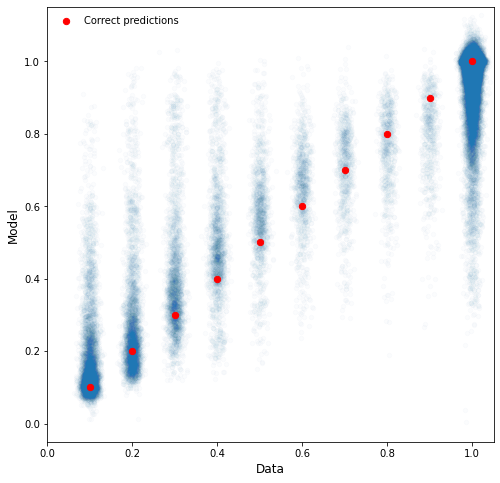

In [9]:
plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title

f, ax = plt.subplots(figsize=(8,8))

(
    pdf
    .assign(jittered = lambda x: x.Data + np.random.normal(0, 0.01, x.shape[0]))
    .plot
    .scatter(
        x='jittered',
        y='Model',
        alpha=0.015,
        ax=ax,
    )
)


ax.scatter(np.arange(0.1, 1.1, 0.1), np.arange(0.1, 1.1, 0.1), c='r', s=40, label='Correct predictions')
        
ax.set_xlim([0, 1.05])
ax.set_ylim([-0.05, 1.15])

ax.set_xlabel('Data')
ax.set_ylabel('Model')

ax.legend(
    loc='upper left',
    framealpha=0,
)

# Save

In [10]:
f.savefig('../figures/paper/app2_fig2.jpg', dpi=1200, bbox_inches="tight")

# R squared value

In [11]:
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
slope, intercept, r_value, p_value, std_err = linregress(pdf.Data, pdf.Model)

r_value**2

0.898469921628296